<h1><center>ANALYSIS OF CROP DAMAGE FROM HAIL </center></h1>

# 1. Set initial configuration 

In [1]:
from sentinelhub import SHConfig

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

# 2. Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from utils import plot_image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotImage import *

from sentinelhub import (
    SentinelHubStatistical,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    Geometry, 
    SHConfig, 
    parse_time, 
    parse_time_interval, 
    SentinelHubStatisticalDownloadClient    
)

# 3. NDVI calculation


The Normalized Difference Vegetation Index (NDVI) is an indicator of plant nitrogen content, health and yield (1). The estimation of this index is based on a band ratio between the RED (Sentinel-2 Band 4) and NIR (Sentinel-2 Band 8) bands as follows: (NIR - RED)/(NIR + RED). As a result, an index in the scale of -1 to +1 is retrieved, where higher values correspond to better plant health conditions. After obtaining the NDVI, an analysis of change between the image pre-hail event and the images post-hail event was applied by calculating the following formula: (NDVIprehail - NDVIposthail)/(NDVIprehail + NDVIposthail). The results were obtained on a scale of -1 to +1 as well, meaning that values further from zero and closer to -1 or +1 experienced the highes magntude og change (1).

In [75]:
#evalscript for ndvi calculation
evalscript_ndvi = """
    VERSION=3
    function setup() {
      return{
        input: [{
          bands: ["B04", "B08"],
          units: "DN"
        }],
        output: {
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        }
      }
    }
    
    function evaluatePixel(sample) {
      let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
      return [ ndvi ]     
}   
"""


In [76]:
#evalscript for statistics calculation
evalscript_statistics = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "SCL",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}


function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)
    
    var validNDVIMask = 1
    if (samples.B04 + samples.B08 == 0 ){ //check if all the bands are 0
        validNDVIMask = 0
    }
    
    var noWaterMask = 1
    if (samples.SCL == 6 ){ //check if pixels are classified as water using SCL band
        noWaterMask = 0
    }

    return {
        ndvi: [ndvi],
        dataMask: [samples.dataMask * validNDVIMask * noWaterMask]  //if even one of the three exclusion criteria is 0, the pixel will be excluded
    }
}

"""

calculations = {
    "default": {
        "statistics": {
            "default": {
                "percentiles": {
                    "k": [],
                    "interpolation": "higher"
                }
            }
        }
    }
}

NDVI CALCULATION BEFORE THE OCCURRENCE OF THE EVENT (2020.07.03): NDVI was calculated from a day before the hail event, the image has optimum conditions without cloud coverage over the analyzed area.

In [125]:
bbox = BBox(bbox=[409215.60, 5490996.56, 433052.18, 5502052.76], crs=CRS('32613'))

In [126]:
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-03', '2020-07-03'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response1 = request.get_data()

NDVI CALCULATION AFTER THE OCCURRENCE OF THE EVENT JULY 6, 16, 28: Three dates were selected to assess the impact of hail over time. These images were chosen due to the limited or nonexistent cloud coverage over the area.

In [79]:
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-06', '2020-07-06'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response1 = request.get_data()

In [81]:
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-16', '2020-07-16'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response3 = request.get_data()

In [87]:
request = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2020-07-28', '2020-07-28'),          
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    bbox=bbox,
    size=[2384, 1106],
    config=config
)

response5 = request.get_data()

CHANGE DETECTION: As described previously, the magnitude of change was calculated based on the formula: (NDVIprehail - NDVIposthail)/(NDVIprehail + NDVIposthail)

In [88]:
NDVIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
NDVIchange03_16 = (response[0]-response3[0])/((response[0]+response3[0]))
NDVIchange03_28 = (response[0]-response5[0])/((response[0]+response5[0]))

C:\Users\lucia\AppData\Local\Temp\ipykernel_18912\2907326177.py:1: RuntimeWarning: invalid value encountered in true_divide
  NDVIchange03_06 = (response[0]-response1[0])/((response[0]+response1[0]))
C:\Users\lucia\AppData\Local\Temp\ipykernel_18912\2907326177.py:3: RuntimeWarning: divide by zero encountered in true_divide
  NDVIchange03_16 = (response[0]-response3[0])/((response[0]+response3[0]))


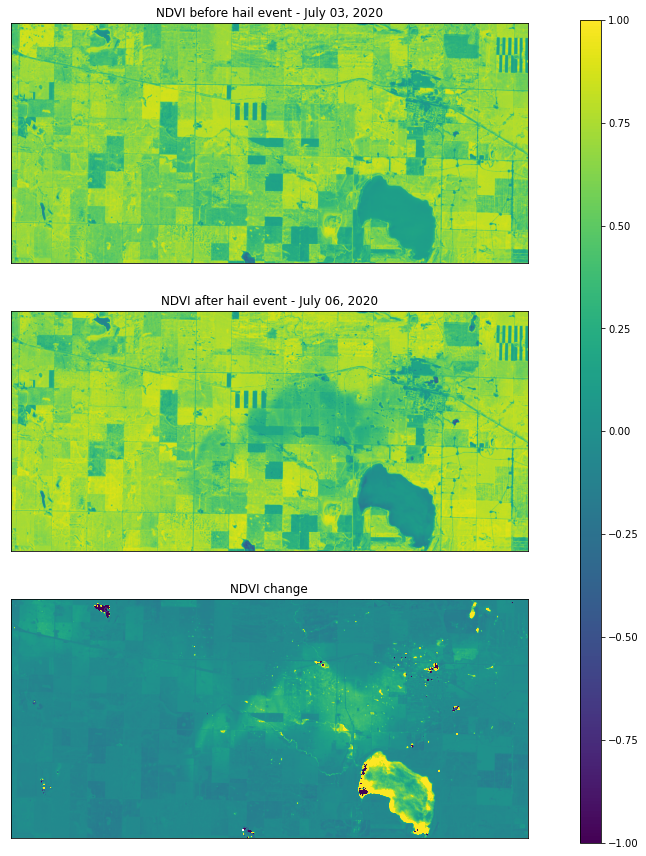

In [108]:
ndvi_july3 = response[0]
ndvi_july6 = response1[0]
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(ndvi_july3)
im = ax0.imshow(ndvi_july3, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDVI before hail event - July 03, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(ndvi_july6)
im2 = ax1.imshow(ndvi_july6, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDVI after hail event - July 06, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDVIchange)
im3 = ax2.imshow(NDVIchange, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDVI change')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

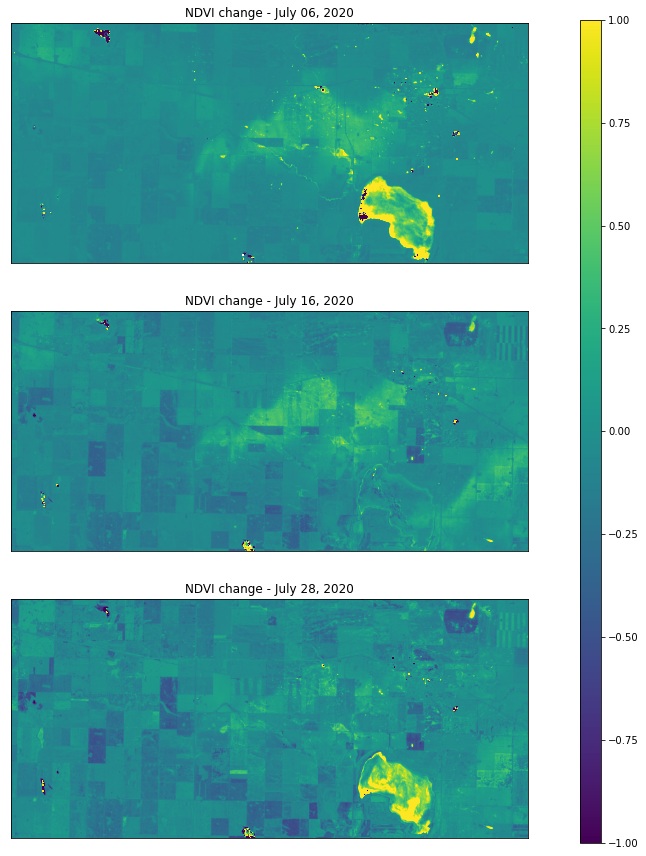

In [91]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(NDVIchange03_06)
im = ax0.imshow(NDVIchange03_06, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax0)
ax0.set_title('NDVI change - July 06, 2020')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(NDVIchange03_16)
im2 = ax1.imshow(NDVIchange03_16, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax1)
ax1.set_title('NDVI change - July 16, 2020')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDVIchange03_28)
im3 = ax2.imshow(NDVIchange03_28, vmin=-1.0, vmax=1.0)
divider = make_axes_locatable(ax2)
ax2.set_title('NDVI change - July 28, 2020')
ax2.set_xticks([])
ax2.set_yticks([])

cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
cbar = fig.colorbar(im, cax=cb_ax)

DEFINITION OF THRESHOLDS

In [123]:
NDVIchange_thres06 =  np.where((NDVIchange03_06>=0.15) & (NDVIchange03_06<=0.33),1,0)
NDVIchange_thres16 =  np.where((NDVIchange03_16>=0.15) & (NDVIchange03_16<=0.33),1,0)
NDVIchange_thres28 =  np.where((NDVIchange03_28>=0.15) & (NDVIchange03_28<=0.33),1,0)

count_pixels = (NDVIchange_thres06 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 06, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)

count_pixels = (NDVIchange_thres16 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 16, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)

count_pixels = (NDVIchange_thres28 == 1).sum()
affected_area_square_km = count_pixels * 100/1000000
print("On July 28, the number of pixels with value 1 that represent to the affected area are:", count_pixels, "in square kilometers the affected area was:", affected_area_square_km)


On July 06, the number of pixels with value 1 that represent to the affected area are: 161552 in square kilometers the affected area was: 16.1552
On July 16, the number of pixels with value 1 that represent to the affected area are: 164801 in square kilometers the affected area was: 16.4801
On July 28, the number of pixels with value 1 that represent to the affected area are: 109229 in square kilometers the affected area was: 10.9229


[]

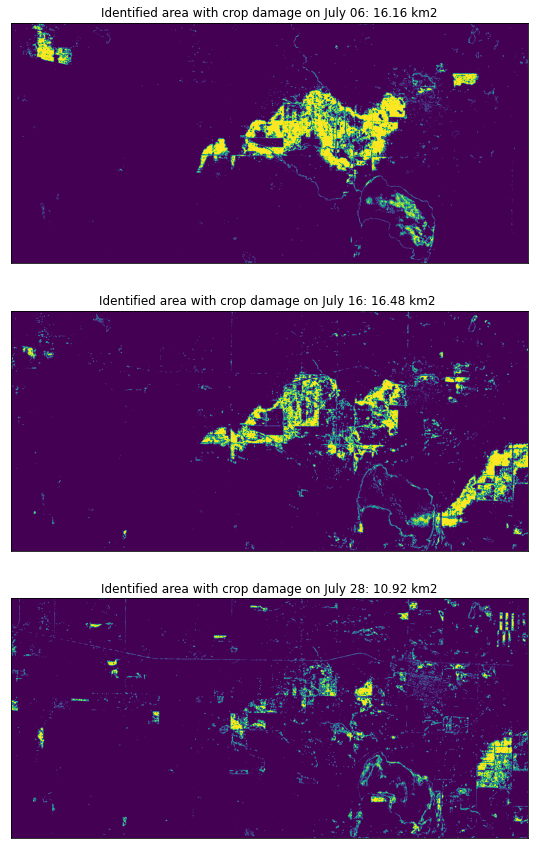

In [124]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
    

im = ax0.imshow(NDVIchange_thres06)
im = ax0.imshow(NDVIchange_thres06)
divider = make_axes_locatable(ax0)
ax0.set_title('Identified area with crop damage on July 06: 16.16 km2')
ax0.set_xticks([])
ax0.set_yticks([])

im2 = ax1.imshow(NDVIchange_thres16)
im2 = ax1.imshow(NDVIchange_thres16)
divider = make_axes_locatable(ax1)
ax1.set_title('Identified area with crop damage on July 16: 16.48 km2 ')
ax1.set_xticks([])
ax1.set_yticks([])

im3 = ax2.imshow(NDVIchange_thres28)
im3 = ax2.imshow(NDVIchange_thres28)
divider = make_axes_locatable(ax2)
ax2.set_title('Identified area with crop damage on July 28: 10.92 km2')
ax2.set_xticks([])
ax2.set_yticks([])

#cb_ax = fig.add_axes([0.80, 0.121, 0.02, 0.762])
#cbar = fig.colorbar(im, cax=cb_ax, ticks=np.linspace(0, 1))
#cbar.set_ticks([0,1])

MAIN REMARKS:
- A very clear and large affected area is visible in the North-West of the pond. On July 16, an important area appeared on the Eastern side of the study area, which was not identified during the first assessment on July 06.
- Overall, the extent of the afected area experienced a minor increment on July 16, and later on, it reduced significantly by July 28.  
- It still remains as an aspect of further analysis the appearance of the important affected area on the Eastern of the study area by July 16, and if the cause was the hail event. 
- The application of a mask of water bodies is missing on this analysis. Therefore, the calculation of the affected area is slightly overestimated. 

## REFERENCES 

(1) Ha T, Shen Y, Duddu H, Johnson E, Shirtliffe SJ. Quantifying Hail Damage in Crops Using Sentinel-2 Imagery. Remote Sensing. 2022; 14(4):951. https://doi.org/10.3390/rs14040951